# Filtering
![dandelion_logo](img/dandelion_logo_illustration.png)

We now move on to filtering out BCR contigs (and corresponding cells if necessary) from the BCR data and transcriptome object loaded in *scanpy*.

**Import *dandelion* module**

In [1]:
import os
import dandelion as ddl
# change directory to somewhere more workable
os.chdir(os.path.expanduser('/Users/kt16/Downloads/dandelion_tutorial/'))
ddl.logging.print_header()

dandelion==0.1.2.dev3 pandas==1.2.3 numpy==1.20.1 matplotlib==3.3.4 networkx==2.5 scipy==1.6.1 skbio==0.5.6


**Import modules for use with scanpy**

In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata

warnings.filterwarnings('ignore')
sc.logging.print_header()

scanpy==1.6.0 anndata==0.7.6 umap==0.4.6 numpy==1.20.1 scipy==1.6.1 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.1 python-igraph==0.8.3 leidenalg==0.8.3


**Import the transcriptome data**

In [3]:
samples = ['sc5p_v2_hs_PBMC_1k', 'sc5p_v2_hs_PBMC_10k', 'vdj_v1_hs_pbmc3', 'vdj_nextgem_hs_pbmc3']
adata_list = []
for sample in samples:
    adata = sc.read_10x_h5(sample +'/' + sample + '_filtered_feature_bc_matrix.h5', gex_only=True)
    adata.obs['sampleid'] = sample
    # rename cells to sample id + barcode
    adata.obs_names = [str(sample)+'_'+str(j) for j in adata.obs_names]
    adata.var_names_make_unique()
    adata_list.append(adata)
adata = adata_list[0].concatenate(adata_list[1:])
# rename the obs_names again, this time cleaving the trailing -#
adata.obs_names = [str(j).split('-')[0] for j in adata.obs_names]
adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 30471 × 31915
    obs: 'sampleid', 'batch'
    var: 'feature_types', 'genome', 'gene_ids-0', 'gene_ids-1', 'gene_ids-2', 'gene_ids-3'

I'm using a wrapper called `pp.recipe_scanpy_qc` to run through a generic [scanpy](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) workflow. You can skip this if you already have a pre-processed `AnnData` object for the subsequent steps.

In [4]:
ddl.pp.recipe_scanpy_qc(adata)
adata

AnnData object with n_obs × n_vars = 30471 × 31915
    obs: 'sampleid', 'batch', 'scrublet_score', 'n_genes', 'percent_mito', 'n_counts', 'is_doublet', 'filter_rna'
    var: 'feature_types', 'genome', 'gene_ids-0', 'gene_ids-1', 'gene_ids-2', 'gene_ids-3'

To proceed, the `.obs` need to contain a `filter_rna` column.

If you have a pre-processed/filltered `AnnData` object that is ready, just add a `'filter_rna'` column into the `.obs` slot with every value set to `False` and you should be good to go:

```python
adata.obs['filter_rna'] = False
```

In [5]:
# adata.obs['filter_rna'] = False

**Filter cells that are potental doublets and poor quality in both the V(D)J data and transcriptome data**

We use the function `pp.filter_contigs` to mark and filter out cells and contigs from both the V(D)J data and transcriptome data in `AnnData`. The operation will remove bad quality cells based on transcriptome information as well as remove V(D)J doublets (multiplet heavy/long chains, and/or light/short chains) from the V(D)J data. In some situations, a single cell can have multiple heavy/long and light/short chain contigs although they have an identical V(D)J+C alignment; in situations like this, the contigs with lesser umis will be dropped and the umis transferred to duplicate_count column. The same procedure is applied to both heavy chain and light chains before identifying doublets. 

Cells in the gene expression object without V(D)J information will not be affected which means that the `AnnData` object can hold non-B/T cells. Run `?ddl.pp.filter_contigs` to check what each option does.

In [6]:
# first we read in the 4 bcr files
bcr_files = []
for sample in samples:
    file_location = sample +'/dandelion/data/'+sample+'_b_filtered_contig_igblast_db-pass_genotyped.tsv'
    bcr_files.append(pd.read_csv(file_location, sep = '\t'))
bcr = bcr_files[0].append(bcr_files[1:])
bcr.reset_index(inplace = True, drop = True)
bcr

,sequence_id,sequence,rev_comp,productive,v_call,d_call,j_call,sequence_alignment,germline_alignment,junction,...,fwr3_aa,fwr4_aa,cdr1_aa,cdr2_aa,cdr3_aa,sequence_alignment_aa,v_sequence_alignment_aa,d_sequence_alignment_aa,j_sequence_alignment_aa,mu_freq
0,sc5p_v2_hs_PBMC_1k_AACTCCCAGGCTAGGT_contig_2,ATACTTTCTGAGAGTCCTGGACCTCCTGTGCAAGAACATGAAACAT...,F,T,IGHV4-61*02,IGHD3-3*01,IGHJ6*02,CAGGTGCAGCTGCAGGAGTCGGGCCCA...GGACTGGTGAAGCCTT...,CAGGTGCAGCTGCAGGAGTCGGGCCCA...GGACTGGTGAAGCCTT...,TGTGCGAGAGAAAATTACGATTTTTGGAGTGGTTATTACCACGGTG...,...,NYNPSLKSRVTISVDTSKNQFSLKLSSVTAADTAVYYC,WGQGTTVTVSS,GGSISSGSYY,IYTSGST,ARENYDFWSGYYHGADV,QVQLQESGPGLVKPSQTLSLTCTVSGGSISSGSYYWSWIRQPAGKG...,QVQLQESGPGLVKPSQTLSLTCTVSGGSISSGSYYWSWIRQPAGKG...,YDFWSGY,YHGADVWGQGTTVTVSS,0.008571
1,sc5p_v2_hs_PBMC_1k_AACTCCCAGGCTAGGT_contig_3,GGCTGGGGTCTCAGGAGGCAGCGCTCTGGGGACGTCTCCACCATGG...,F,F,IGLV2-5*01,NaN,IGLJ3*02,CAGTCTGCCCTGATTCAGCCTCCCTCC...GTGTCCGGGTCTCCTG...,CAGTCTGCCCTGATTCAGCCTCCCTCC...GTGTCCGGGTCTCCTG...,TGCTGCTCATATACAAGCAGTGCCACTTTCTTGGGTGTTC,...,TQPSGVPDRFSGSKSGNTASMTISGLQAEDEADY*C,RRRDQADRP,SSDVGSYDY,NVN,CSYTSSATFLG,QSALIQPPSVSGSPGQSVTISCTGTSSDVGSYDYVSWYQQHPGTVP...,QSALIQPPSVSGSPGQSVTISCTGTSSDVGSYDYVSWYQQHPGTVP...,NaN,LGVRRRDQADRP,0.000000
2,sc5p_v2_hs_PBMC_1k_AACTCCCAGGCTAGGT_contig_1,ACTGCGGGGGTAAGAGGTTGTGTCCACCATGGCCTGGACTCCTCTC...,F,T,IGLV5-45*03,NaN,IGLJ3*02,CAGGCTGTGCTGACTCAGCCGTCTTCC...CTCTCTGCATCTCCTG...,CAGGCTGTGCTGACTCAGCCGTCTTCC...CTCTCTGCATCTCCTG...,TGTATGATTTGGCACAGCAGCGCTTGGGTGTTC,...,QQGSGVPSRFSGSKDASANAGILLISGLQSEDEADYYC,FGGGTKLTVL,SGINVGTYR,YKSDSDK,MIWHSSAWV,QAVLTQPSSLSASPGASASLTCTLRSGINVGTYRIYWYQQKPGSPP...,QAVLTQPSSLSASPGASASLTCTLRSGINVGTYRIYWYQQKPGSPP...,NaN,VFGGGTKLTVL,0.000000
3,sc5p_v2_hs_PBMC_1k_AACTCTTGTCATCGGC_contig_3,AGCAGAGCTCTGGGGAGTCTGCACCATGGCTTGGACCCCACTCCTC...,F,F,IGLV4-69*01,NaN,IGLJ3*02,CAGCTTGTGCTGACTCAATCGCCCTCT...GCCTCTGCCTCCCTGG...,CAGCTTGTGCTGACTCAATCGCCCTCT...GCCTCTGCCTCCCTGG...,TGTCAGACCTGGGGCACTGGCATTCTTGGGTGTTC,...,SKGDGIPDRFSGSSSGAERYLTISSLQSEDEADYYC,SAEGPS*PS,SGHSSYA,LNSDGSH,QTWGTGILG,QLVLTQSPSASASLGASVKLTCTLSSGHSSYAIAWHQQQPEKGPRY...,QLVLTQSPSASASLGASVKLTCTLSSGHSSYAIAWHQQQPEKGPRY...,NaN,GCSAEGPS*PS*,0.000000
4,sc5p_v2_hs_PBMC_1k_AACTCTTGTCATCGGC_contig_1,AGAGCTCTGGGGAGTCTGCACCATGGCTTGGACCCCACTCCTCTTC...,F,T,IGLV4-69*01,NaN,IGLJ1*01,CAGCTTGTGCTGACTCAATCGCCCTCT...GCCTCTGCCTCCCTGG...,CAGCTTGTGCTGACTCAATCGCCCTCT...GCCTCTGCCTCCCTGG...,TGTCAGACCTGGGGCACTGGCATTTATGTCTTC,...,SKGDGIPDRFSGSSSGAERYLTISSLQSEDEADYYC,FGTGTKVTVL,SGHSSYA,LNSDGSH,QTWGTGIYV,QLVLTQSPSASASLGASVKLTCTLSSGHSSYAIAWHQQQPEKGPRY...,QLVLTQSPSASASLGASVKLTCTLSSGHSSYAIAWHQQQPEKGPRY...,NaN,YVFGTGTKVTVL,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7507,vdj_nextgem_hs_pbmc3_TTTGCGCTCTGTCAAG_contig_2,ATCACATAACAACCACATTCCTCCTCTAAAGAAGCCCCCGGGAGCC...,F,T,"IGHV1-69*01,IGHV1-69D*01",IGHD3-22*01,IGHJ4*02,CAGGTGCAGCTGGTGCAGTCTGGGGCT...GAAGTGAAGAAGCCTG...,CAGGTGCAGCTGGTGCAGTCTGGGGCT...GAGGTGAAGAAGCCTG...,TGTGCGAGGGGGAAGTATTACTATGATAAAAGTGGGTCTCCACCTC...,...,NYAQKFQGRVSITADESTTTAYMELSSLRSEDSAVYYC,WGQGTLVTVSS,GGIFSSYA,IIPIFGAT,ARGKYYYDKSGSPPPIYSFDY,QVQLVQSGAEVKKPGSSVKVSCKVSGGIFSSYAISWVRQAPGQGLE...,QVQLVQSGAEVKKPGSSVKVSCKVSGGIFSSYAISWVRQAPGQGLE...,YYYDKSG,FDYWGQGTLVTVSS,0.047619
7508,vdj_nextgem_hs_pbmc3_TTTGGTTGTAAGGATT_contig_1,AGAGCTCTGGAGAAGAGCTGCTCAGTTAGGACCCAGAGGGAACCAT...,F,T,IGKV3-20*01,NaN,"IGKJ2*01,IGKJ2*02",GAAATTGTGTTGACGCAGTCTCCAGGCACCCTGTCTTTGTCTCCAG...,GAAATTGTGTTGACGCAGTCTCCAGGCACCCTGTCTTTGTCTCCAG...,TGTCAGCAGTATGATGAGTCACCTCTGACTTTT,...,SRATGIPDRFSGSGSGTDFTLTISRLVPEDFAVYYC,FGQGTKLEIK,QSLTNSQ,GAS,QQYDESPLT,EIVLTQSPGTLSLSPGERATLSCRASQSLTNSQLAWYQQKPGQAPR...,EIVLTQSPGTLSLSPGERATLSCRASQSLTNSQLAWYQQKPGQAPR...,NaN,TFGQGTKLEIK,0.034161
7509,vdj_nextgem_hs_pbmc3_TTTGGTTGTAAGGATT_contig_2,AGCTCTGGGAGAGGAGCCCCAGCCCTGAGATTCCCAGGTGTTTCCA...,F,T,IGHV3-9*01,"IGHD5-18*01,IGHD5-5*01",IGHJ6*03,GAAGTGCAGCTGGTGGAGTCTGGGGGA...GGCTTGGTACAGCCTG...,GAAGTGCAGCTGGTGGAGTCTGGGGGA...GGCTTGGTACAGCCTG...,TGTGCAAAAGACGGATACAGCTAT

In [7]:
# The function will return both objects. 
vdj, adata = ddl.pp.filter_contigs(bcr, adata)

Scanning for poor quality/ambiguous contigs with 3 cpus


Annotating in anndata obs slot : 100%|██████████| 30471/30471 [00:00<00:00, 240799.62it/s]


Finishing up filtering
Initializing Dandelion object


**Filtering parameters to consider**

- The default mode is to filter any remaining 'doublet' VJ chains (BCR light chains and TCR short chains), but some may be interested in keeping them. The option to change the behaviour is by toggling:
```python
filter_vj_chains=False
```

- If the cell in the V(D)J table cannot be found in the transcriptomic data, it will also be removed from the V(D)J data by default. This can be changed by toggling:
```python
filter_missing=False
```

- When contigs are marked as poor quality, the default behaviour is to remove the contigs associated with the barcode, and not the barcode from the transcriptome data. This can be toggled to remove the entire cell if the intention is to retain a conservative dataset for both V(D)J and transcriptome data:
```python
filter_poorqualitycontig=True
```

- The default behaviour is to rescue the VDJ chain contig with the highest umi if there are multiple contigs for a single cell. The function requires a minimum fold-difference of 2 between the highest and lowest umi in order to rescue the contig. However, if the contigs have similar number of umis, or if the sum of the umis are very low, then the entire cell will be filtered. The fold-difference cut-off can be specified via the option `umi_foldchange_cutoff`. This can be toggled to be ignored i.e. drop all multiple VDJ contigs:
```python
rescue_vdj=False
```

- The default behaviour is to only consider productive contigs but some cell types may require examination of non-productive chains (e.g. developing early B/T cells, ILCs, NKTs etc.). This can be togged with:
```python
productive_only=False
```

- If you just want to mark which contigs to remove and not actually remove them from consideration, this can be toggled with:
```python
filter_contig=False
```

- Lastly, and most importantly, if you want to keep the processed transcriptome data as is, and not make use of the V(D)J data to filter out potentially poor quality cells because of multiplet V(D)J detection, consider using:
```python
filter_rna=False
```
This should keep the `anndata` as per the input but with the `.obs` columns appropriately filled in with the V(D)J QC metrics.

**Check the output V(D)J table**

The vdj table is returned as a `Dandelion` class object in the `.data` slot (described in further detail in the next notebook); if a file was provided for `filter_bcr` above, a new file will be created in the same folder with the `filtered` prefix. Note that this V(D)J table is indexed based on contigs (sequence_id).

In [8]:
vdj

Dandelion class object with n_obs = 1004 and n_contigs = 2013
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon', 'vj_in_frame', 'locus', 'junction_length', 'np1_length', 'np2_length', 'v_sequence_start', 'v_sequence_end', 'v_germline_start', 'v_germline_end', 'd_sequence_start', 'd_sequence_end', 'd_germline_start', 'd_germline_end', 'j_sequence_start', 'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score', 'v_identity', 'v_support', 'd_score', 'd_identity', 'd_support', 'j_score', 'j_identity', 'j_support', 'fwr1', 'fwr2', 'fwr3', 'fwr4', 'cdr1', 'cdr2', 'cdr3', 'cell_id', 'c_call', 'consensus_count', 'umi_count', 'v_call_10x', 'd_call_10x', 'j_call_10x', 'junction_10x', 'junction_10x_aa', 'v_call_genotyped', 'germline_alignment_d_mask', 'sample_id', 'c_sequence_alignment', 'c_germline_alignment', 'c_sequence_start'

**Check the AnnData object as well**

And the `AnnData` object is indexed based on cells.

In [9]:
adata

AnnData object with n_obs × n_vars = 16659 × 31915
    obs: 'sampleid', 'batch', 'scrublet_score', 'n_genes', 'percent_mito', 'n_counts', 'is_doublet', 'filter_rna', 'has_contig', 'filter_contig_quality', 'filter_contig_VDJ', 'filter_contig_VJ', 'contig_QC_pass', 'filter_contig'
    var: 'feature_types', 'genome', 'gene_ids-0', 'gene_ids-1', 'gene_ids-2', 'gene_ids-3'

The `.obs` slot in the `AnnData` object now contains a few new columns related to BCR:

1) **has_contig :** `True/False` statement marking cells with a matching BCR (pre-contig filtering).

2) **filter_contig_quality :** `True/False` recommendation for filtering cells identified as having poor quality contigs if `filter_poorqualitybcr=True` (pre-contig filtering).

3) **filter_contig_VDJ :** `True/False` recommendation for filtering cells identified as heavy chain 'doublets' (after rescue if `rescue_igh=True`) (pre-contig filtering).

4) **filter_contig_VJ :** `True/False` recommendation for filtering cells identifed as having multiple light chain contigs (pre-contig filtering).

***Most importantly:***

5) **contig_QC_pass :** `True/False` statement marking cells where BCR contigs were removed from #1 due to contigs failing QC. (post-contig filtering)

6) **filter_contig :** `True/False` recommendation for filter for cells flagged in 2-4 (post-contig filtering).

So this means that to go forward, you want to only select cells that have BCR that passed QC (`has_bcr == True` and `bcr_QC_pass == True`) with filtering recommendation to be false (`filter_bcr == False`).

**The number of cells that actually has a matching BCR can be tabluated.**

In [10]:
pd.crosstab(adata.obs['has_contig'], adata.obs['filter_contig'])

filter_contig,False
has_contig,
True,1056
No_contig,15603


In [11]:
pd.crosstab(adata.obs['has_contig'], adata.obs['contig_QC_pass'])

contig_QC_pass,False,True,No_contig
has_contig,,,
True,52,1004,0
No_contig,0,0,15603


In [12]:
pd.crosstab(adata.obs['contig_QC_pass'], adata.obs['filter_contig'])

filter_contig,False
contig_QC_pass,
False,52
True,1004
No_contig,15603


**Now actually filter the AnnData object and run through a standard workflow starting by filtering genes and normalizing the data**

Because the 'filtered' `AnnData` object was returned as a filtered but otherwise unprocessed object, we still need to normalize and run through the usual process here. The following is just a standard scanpy workflow.

In [13]:
# filter genes
sc.pp.filter_genes(adata, min_cells=3)
# Normalize the counts
sc.pp.normalize_total(adata, target_sum=1e4)
# Logarithmize the data
sc.pp.log1p(adata)
# Stash the normalised counts
adata.raw = adata

**Identify highly-variable genes**

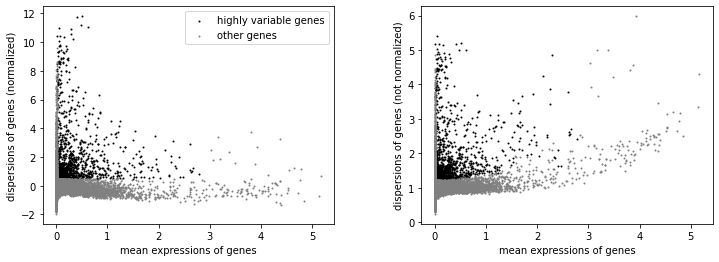

In [14]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

**Filter the genes to only those marked as highly-variable**

In [15]:
adata = adata[:, adata.var.highly_variable]

**Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.**

In [16]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
sc.pp.scale(adata, max_value=10)

Trying to set attribute `.obs` of view, copying.
... storing 'sampleid' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'feature_types' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'genome' as categorical


**Run PCA**

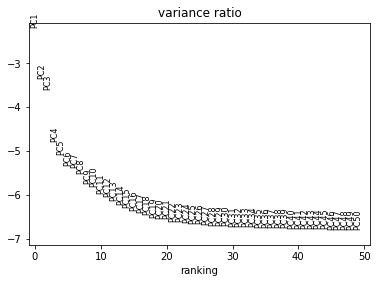

In [17]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

**Computing the neighborhood graph, umap and clusters**

In [18]:
# Computing the neighborhood graph
sc.pp.neighbors(adata)
# Embedding the neighborhood graph
sc.tl.umap(adata)
# Clustering the neighborhood graph
sc.tl.leiden(adata)

**Visualizing the clusters and whether or not there's a corresponding V(D)J receptor**

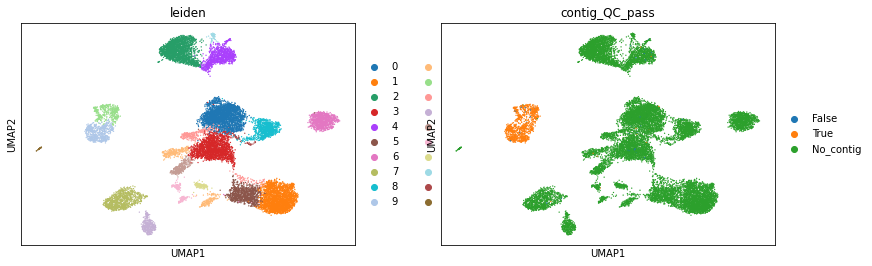

In [19]:
sc.pl.umap(adata, color=['leiden', 'contig_QC_pass'])

**Visualizing some B cell genes**

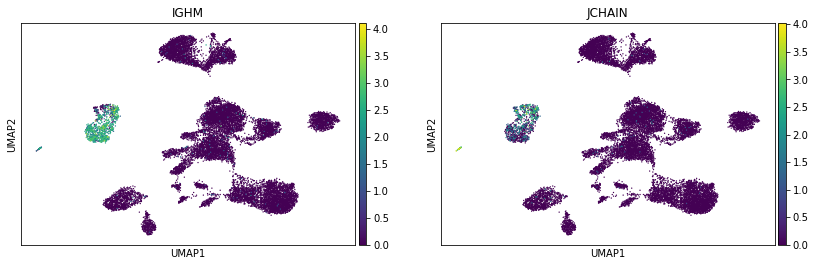

In [20]:
sc.pl.umap(adata, color=['IGHM', 'JCHAIN'])

**Save AnnData**

We can save this `AnnData` object for now.

In [21]:
adata.write('adata.h5ad', compression = 'gzip')

... storing 'feature_types' as categorical
... storing 'genome' as categorical


**Save dandelion**

To save the vdj object, we have two options - either save the `.data` and `.metadata` slots with pandas' functions:

In [22]:
vdj.data.to_csv('filtered_vdj_table.tsv', sep = '\t')

Or save the whole Dandelion class object with either `.write_h5`, which saves the class to a HDF5 format, or using a pickle-based `.write_pkl` function.

In [23]:
vdj.write_h5('dandelion_results.h5', complib = 'bzip2')

In [24]:
vdj.write_pkl('dandelion_results.pkl.pbz2') # this will automatically use bzip2 for compression, swith the extension to .gz for gzip